# Responsible AI

Responsible AI refers to the practice of developing and deploying artificial intelligence systems in a manner that prioritises ethical considerations, fairness, transparency, accountability, and the overall well-being of individuals and society. It encompasses a set of principles, guidelines, and techniques aimed at mitigating potential risks, biases, and unintended consequences associated with AI technologies.

This notebook demonstrates how two key principles of responsible AI can be implemented in practice: fairness and transparency.

## Data

In this notebook we will use the COMPAS dataset to demonstrate how bias in models can be identified and how more transparent models without this bias can be trained.

The COMPAS dataset contains information on over 10,000 defendants assessed using the COMPAS tool in Broward County, Florida, between 2013 and 2014. It includes demographic data, criminal history, and details about prior offenses, aiming to predict the likelihood of recidivism. However, concerns have been raised regarding fairness and bias in the COMPAS predictions, as studies have shown disparities across racial and ethnic groups. It therefore provides a good basis for demonstrating how bias in datasets can be identified and mitigated.

The COMPAS data used was obtained from ProPublica at https://github.com/propublica/compas-analysis.

In [1]:
import pandas as pd

# load conpas data and view columns
compas_df = pd.read_csv("compas.csv")

#filter to recidivism only
compas_rec_df = compas_df[compas_df['type_of_assessment'] == "Risk of Recidivism"]

#load person data
person_df = pd.read_csv("person.csv")

#view first rows
pd.set_option('display.max_columns', None)

# Detecting Bias

AI systems can inadvertently perpetuate biases present in the data they are trained on, leading to unfair or discriminatory outcomes. To address this issue, it is essential to actively identify and mitigate bias in AI models.

Fairlearn (https://fairlearn.org/) is an open-source community driven project that helps improve fairness in AI systems. It does this by providing a toolkit that allows users to assess for bias in machine learning models through various metrics and through applying algorithms to trained models to mitigate bias that might be present.

Below we will use Fairlearn to identify bias in the predictions made by COMPAS.

In [2]:
#import necessary libraries
import fairlearn
import sklearn

# create a df to test fairness of predictions
fairness_test_df = person_df[['race', 'decile_score', 'is_recid']]

#filter out rows with unknown recidivism
fairness_test_df = fairness_test_df[fairness_test_df['is_recid'] != -1]

#function to set recidivism prediction based on compas decile score
# 1-5 = not recidivate coded as 0
# 6-10 = recidivate coded as 1

def compas_pred(decile_score):
    if 0 <= decile_score <= 5:
        return 0
    else:
        return 1
    
#apply function
fairness_test_df['compas_pred'] = fairness_test_df.apply(lambda x: compas_pred(x['decile_score']), axis=1)

#drop decile score
fairness_test_df = fairness_test_df.drop('decile_score', axis=1)

#view dataframe
fairness_test_df.head()

,race,is_recid,compas_pred
0,Other,0,0
2,African-American,1,0
3,African-American,1,0
4,African-American,0,1
5,Other,0,0


### Fairness Metrics

Fairness can have different definitions in the context of AI. However generally fairness in AI involves removing bias from our models. Bias in models can result in different treatment of groups in a way that undermines our notion of fairness. 

There are several different fairness metrics that can be used to identify if there is bias in models.

| Fairness Metric    | Description                                                    |
|--------------------|----------------------------------------------------------------|
| Demographic parity | The proportion of positive cases are close for each sub-group. |
| Accuracy parity    | The accuracies of each subgroup are close to each other.       |
| M3                 | d3                                                             |
| m4                 | d4                                                             |
| m5                 | d5                                                             |
| m6                 | d6                                                             |
|                    |                                                                |
|                    |                                                                |
|                    |                                                                |


>*Equalised Odds* is a metric that tests whether a prediction model provides similar accuracy for different groups. Equalised odds measures the difference in >error rates between different groups. An equalised odds score will be between -1 and 1, with scores closer to 1 representing a more fair model which in this >context means that the true positive and false positive rates across groups are similar.

>*False positive rate* is a common measure which measures the proportion of positive predictions that are incorrect. This metric is of particular importance >in the case of COMPAS as it represents the case where we incorrectly predict someone is recidivist. Where we incorrectly predict someone is likely to >recidivate, they are more likely to be punished.

In [3]:
#import fairlearn fairness assessment libraries
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate, false_negative_rate,equalized_odds_difference

y_true = fairness_test_df['is_recid']
y_pred = fairness_test_df['compas_pred']
sf_data = fairness_test_df['race']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'fnr' : false_negative_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_true,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_true, y_pred,sensitive_features=sf_data)

#view equalised odds score
print(eq_odds)

0.5224775224775225


An equalised odds score of around 0.5 shows that the model is moderately fair in its predictions but that there is room for improvement. The next step is to examine more detailed metrics across all groups.

In [4]:
#print metrics
print(metric_frame.by_group)

                       fpr       tpr       fnr   count
race                                                  
African-American  0.400782  0.618391  0.381609  5501.0
Asian             0.071429  0.545455  0.454545    53.0
Caucasian         0.179919  0.392103  0.607897  3818.0
Hispanic          0.159091  0.325670  0.674330  1009.0
Native American   0.217391  0.769231  0.230769    36.0
Other             0.109208  0.246753  0.753247   621.0


This more detailed view shows us the ways in which the COMPAS predictions exhibit bias. 

We can see that the COMPAS predictions have a high false positive rate for African-Americans compared to other groups. In the context of COMPAS, this most likely means that African-American defendants are less likely to be granted release before a trial or would be more likely to receive longer sentenced during sentencing.

We can also a disparity between groups in false negative rates. African Americans have a relatively low false negative rate while Caucasian and Hispanics have larger false negative rates. In practice what this means is that individuals from the Caucasian and Hispanic groups are more likely to be incorrectly judged to not recidivate and thus a lower risk to the public. This produces the opposite of the scenario for African-Americans above where Caucasian and Hispanic are more likely to be release on pre-trial bail or receive less severe sentences.

Finally, Fairlearn supports some basic plotting for visualising the metrics generated.

array([[<Axes: title={'center': 'fpr'}, xlabel='race'>]], dtype=object)

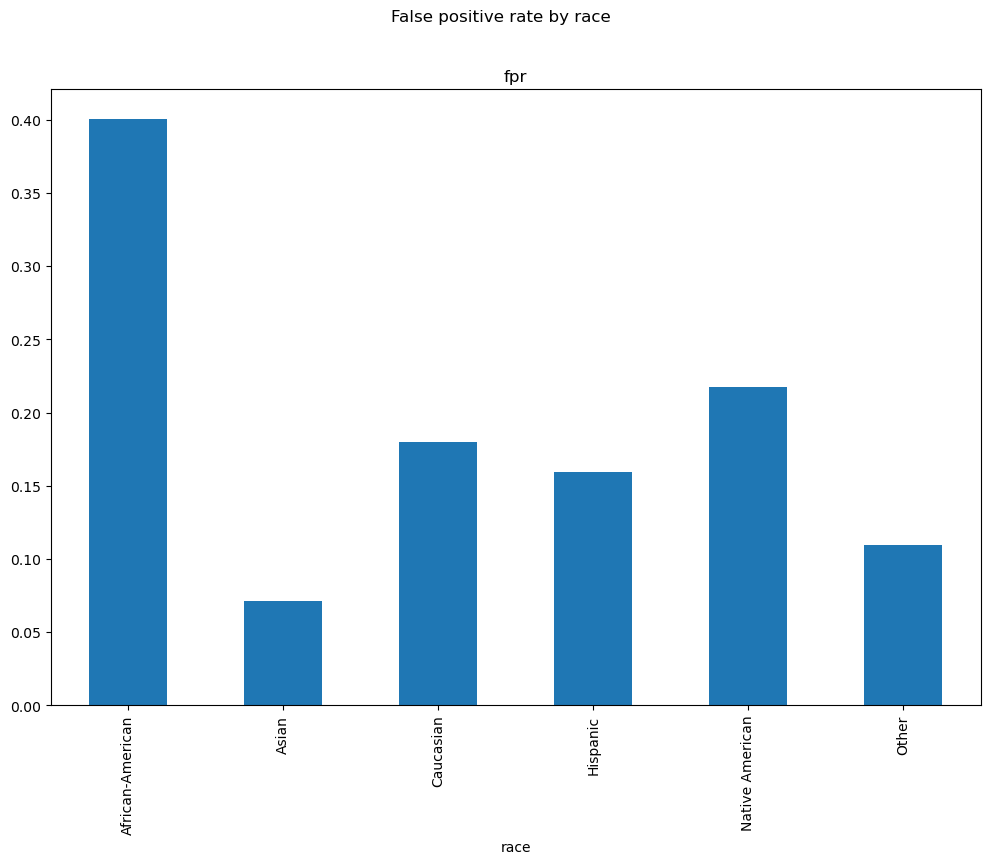

In [5]:
#visualise the false positive rate by race
#barplot of false positive rate
metric_frame.by_group[["fpr"]].plot(
    kind="bar",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="False positive rate by race",
)

# Mitigating Bias

Once bias has been identified in a model it should be mitigated so that the AI systems we develop are fair. There are three different stages of model development where we can mitigate bias:
- Pre-processing: Manipulating the data we use to train a model to remove bias before it is fed into a model
- In-processing: Bias mitigation techniques applied to model training
- Post-processing: Bias mitigation techniques after the model has been trained

Where we apply bias mitigation techniques will depend on the specific circumstances of our case.


We are not able to mitigate bias in the COMPAS model itself as we don't have access, however we will train a new model and mitigate bias within that model as a demonstration of how bias mitigation techniques can be applied in practice. In particular, we will focus on in-processing and post-processing mitigation techniques.

### Train a new model

To train a new model, we will use InterpretML (https://interpret.ml/). InterpretML is a toolkit that enables training models that are more interpretable and explainable. 
One of the key features of responsible AI is that AI systems should be transparent. Transparency is in large part achieved by developing AI models that are interpretable and explainable.

>*Interpretable AI* is AI where humans can understand the decision-making process of an AI system. Specifically, this is about how well the inner workings of an AI system be can understood by a human.
>
>*Explainable AI* refers to the ability of an AI system to provide clear and understandable justification for its decisions. Specificially the system should be able to provide a clear and transparent explanation for why it make a particular decision.


We will use InterpretML to train a model to predict recidivism based on the COMPAS data.

In [6]:
#identify the columns that will be kept 
keep_cols = ['sex', 'race', 'age', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'is_recid']
train_df = person_df[keep_cols]

#filter out rows with unknown recidivism outcome
train_df = train_df[train_df['is_recid'] != -1]

#remove rows with missing values
train_df = train_df.dropna()

#view data that will be used to train the model
train_df.head()

,sex,race,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid
0,Male,Other,69,Greater than 45,0,0,0,0,(F3),Aggravated Assault w/Firearm,0
2,Male,African-American,34,25 - 45,0,0,0,0,(F3),Felony Battery w/Prior Convict,1
3,Male,African-American,24,Less than 25,0,0,1,4,(F3),Possession of Cocaine,1
4,Male,African-American,23,Less than 25,0,1,0,1,(F3),Possession of Cannabis,0
5,Male,Other,43,25 - 45,0,0,0,2,(F7),arrest case no charge,0


In [7]:
#import libraries
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#create train/test split
train, test = train_test_split(train_df, test_size=0.2)

x_train = train.loc[:, train.columns != 'is_recid']
y_train = train.loc[:, train.columns == 'is_recid']

x_test = test.loc[:, test.columns != 'is_recid']
y_test = test.loc[:, test.columns == 'is_recid']

#### Explainable Boosting Machine (EBM)

EBM is an example of a *glassbox model*. 

>*Glassbox models* are designed for explainability, meaning that the model can clearly explain how it made its predictions. This is in contrast to *blackbox >models* where explanations are not direct.

EBM is a tree-based model that uses gradient boosting with an ensemble of decision trees. EBM models have high accuracy and allow effective visualisation of how a model makes its predictions.

Due to their high accuracy and inherent explainability, EBM models provide a good default model for AI systems.

In [8]:
#train a explainable boosting classifier
ebm = ExplainableBoostingClassifier()
ebm.fit(x_train, y_train)

#model performance
y_pred = ebm.predict(x_test)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6970935513169846
Precision: 0.6614157576795966
Recall: 0.6104514413001745
F1 Score: 0.6124674568063067


The model performs modestly well with all metrics ranging between 0.60 and 0.70.


InterpretML provides useful visualisations that make the model explanations accessible to people. The visualisation shows both which features are most important for making a prediction and how the values within each variable influence the prediction (for example, within the 'sex' variable we can see specifically how 'male' will impact the overall prediction and separately how 'female' will impact the overall prediction). 

Selecting 'Summary' in the below will show the overall influence of separate variables in making a prediction. Selecting individual variables will show how the values of that specific variable impact a prediction.

In [9]:
from interpret import show

#explain the overall model
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2499730532496/ -->

From the explanation provide, we can see that:
- Priors count, age, type of charge and race are the top predictors of whether an individual will recidivate
- The higher the priors are, the more likely it is someone will recidivate. However interestingly fewer than 2 priors is associated with a lower likelihood to recidivate.
- Younger ages are associated with a higher likelihood to recidivate. Those below 30 have an increased probability for recidivating while those above 30 have a decreased likelihood to recidivate.
- Being female will reduce the probability scoring of the predictor while being male will result in a very slightly increased likelihood.
- All races except for African-American are associated with a lower likelihood to recidivate, African-Americans will receive a higher score when predicting recidivism

In [10]:
#explain individual predictions
ebm_local = ebm.explain_local(x_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2499730532832/ -->

The local explainer shows what the model predicted for each case, the probability associated with that prediction and how each feature impacted that prediction. This provides an extremely useful explanation for human users of that prediction. 

For example, examining prediction 1 reveals that:
- The prediction was wrong with a high level of confidence. The model predicted that the person would not recidivate with a confidence of 0.895, the person did recidivate.
- The largest contributors that led to this high level of confidence were the fact that the individual did not have any priors, was older and female and was caucasian.
- There are some interaction variables that increase the likelihood of recidivating, this is race and age and race and juvenile offences. This demonstrates that while age and race are individually leading to a lower prediction, the interaction is capturing the nuance that being both older and caucasian actually presents a higher probability of recidivating.

#### Assessing Bias 

A bias assessment of a trained model focuses on the impact the model has on specific groups and whether this impact is biased or not.

The overall model explanation above showed that there are two sensitive features that have high predictive value and therefore could be influencing model bias: age and race. We will check for model bias in both of these features.

In [11]:
#test for bias in age
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate, equalized_odds_difference

#define sensitive features
sf_data = x_test['race']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

In [12]:
eq_odds

0.5

Equal odds show a difference in performance between groups for the face feature. Examining the actual false positive and true positive rates will reveal where the actual bias is emerging.

In [13]:
metric_frame.by_group

,fpr,tpr,count
race,,,
African-American,0.199102,0.440449,1113.0
Asian,0.000000,0.000000,13.0
Caucasian,0.037244,0.187500,761.0
Hispanic,0.051852,0.150943,188.0
Native American,0.000000,0.500000,6.0
Other,0.063158,0.230769,121.0


There are significant disparities across groups for both false positive and true positive rates. From these we can observe that:
- African-Americans and Native Americans have the highest false positive rate, meaning that they are more likely to be incorrectly judged recidivist.
- The true positive rate for Asian, Caucasian and Other are lower, meaning they are more likely to be incorrectly judged to not be recidivist.

The differences in false and true positive rates here do provide reason to introduce bias mitigation measures. If we were to continue with this model, it would be the case that African-Americans and Native Americans are at least 3 times more likely to be incorrectly labeled as likely to recidivate compared to other groups.

In [14]:
#test for bias in age
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate, equalized_odds_difference

#define sensitive features
sf_data = x_test['age_cat']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

print(eq_odds)

0.3279975967728092


In [15]:
metric_frame.by_group

,fpr,tpr,count
age_cat,,,
25 - 45,0.121859,0.356009,1237.0
Greater than 45,0.028497,0.106557,508.0
Less than 25,0.218045,0.434555,457.0


Observing this we can see a disparity in true and false positive rates. Specifically, the 'Greater than 45' category has much lower false and true positive rates compared to the other categories. 

### Applying Fairlearn to Mitigate Bias

We will deal with mitigating bias for both age and race.

In [16]:
from fairlearn.reductions import FalsePositiveRateParity

fprp = FalsePositiveRateParity(difference_bound=0.01)
sensitive_features = x_test['race']


fprp.load_data(x_test, y_test, sensitive_features=sensitive_features)
fprp.gamma(lambda X: y_pred)

sign  event    group_id        
+     label=0  African-American    0.084461
               Asian              -0.114641
               Caucasian          -0.077397
               Hispanic           -0.062789
               Native American    -0.114641
               Other              -0.051483
-     label=0  African-American   -0.084461
               Asian               0.114641
               Caucasian           0.077397
               Hispanic            0.062789
               Native American     0.114641
               Other               0.051483
dtype: float64

### Post-processing

We will apply threshold optimization.

In [17]:
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
                    estimator=ebm,
                    constraints="false_positive_rate_parity",
                    objective="balanced_accuracy_score",
                    prefit=True,
                    predict_method="predict_proba"
)

sensitive_features = x_train['race']

In [18]:
#train model with fairness constraint
fair_ebm = postprocess_est.fit(x_train, y_train, sensitive_features=sensitive_features)

In [19]:
#assess model

sensitive_features = x_test['race']

#model performance
y_pred = fair_ebm.predict(x_test, sensitive_features=sensitive_features)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6471389645776566
Precision: 0.6381890888317624
Recall: 0.6528780207218958
F1 Score: 0.6342736095984918


In [20]:
#define sensitive features
sf_data = x_test['race']

#common metrics
metrics = {
    'fpr' : false_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

print(eq_odds)

0.375


In [21]:
#view metrics
metric_frame.by_group

,fpr,count
race,,
African-American,0.389222,1113.0
Asian,0.666667,13.0
Caucasian,0.331471,761.0
Hispanic,0.377778,188.0
Native American,0.500000,6.0
Other,0.336842,121.0


Applying a threshold optimizer to optimise for parity in false positive rates produces interesting results.

Firstly we see that equalised odds has improved slightly, reducing from 0.5 to 0.4. However the detail of this change reveals something interesting. 

The false positive rates are steady across most groups (around 0.3) except for the Asian group qhich has a false positive rate of 0.7. This is in stark contrast to the previously trained model which had a false positive rate of 0 for the Asian group and which had a maximum false positive rate of 0.18.

While we introduce parity across most groups for false positive rate, it introduces an extremely high false positive rate for one group which would not be acceptable in practice. This highlights an important consideration in fairness. Fairness is not just about parity but is also about a threshold for the overall outcome for specific groups.

# Summary

In summary...